In [44]:
import seaborn as sns
# set font-scale
sns.set(style="whitegrid", context="notebook",font_scale=1.2)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [45]:
PV = "sex"
if PV == "age":
    groups = ["old", "young"]
else:
    groups = ["male", "female"]
metrics = [
    (f"test/lungOpacity_{groups[0]}_fpr@0.95", f"test/lungOpacity_{groups[1]}_fpr@0.95", "fpr@0.95tpr"),
    (f"test/lungOpacity_{groups[0]}_tpr@0.05", f"test/lungOpacity_{groups[1]}_tpr@0.05", "tpr@0.05fpr"),
    (f"test/lungOpacity_{groups[0]}_anomaly_score", f"test/lungOpacity_{groups[1]}_anomaly_score", "anomaly score"),
    (f"test/lungOpacity_{groups[0]}_AUROC", f"test/lungOpacity_{groups[1]}_AUROC", "AUROC"),
    (f"test/lungOpacity_{groups[0]}_subgroupAUROC", f"test/lungOpacity_{groups[1]}_subgroupAUROC", "subgroupAUROC"),
    (f"test/lungOpacity_{groups[0]}_AP", f"test/lungOpacity_{groups[1]}_AP", "AP")
]
metrics_unwrapped = [item for sublist in [m[0:2] for m in metrics] for item in sublist]

In [46]:
def load_csvs_into_df(dir):
    dirs = [os.path.join(dir,d) for d in os.listdir(dir) if os.path.isdir(os.path.join(dir,d))]
    dfs = []
    for d in dirs:
        seeds = [f for f in os.listdir(os.path.join('./',d)) if f.startswith('seed')]
        for seed in seeds:
            results = [f for f in os.listdir(os.path.join(d,seed)) if f.startswith('test_results')][0]
            results_df = pd.read_csv(os.path.join(d, seed, results))
            dfs.append(results_df)
    df = pd.concat(dfs)
    return df

In [47]:
df = load_csvs_into_df('./')
df = df[['seed','job_type_mod',*metrics_unwrapped,'protected_attr_percent']]
df = pd.melt(df, id_vars=['seed','protected_attr_percent','job_type_mod'])
df.job_type_mod = df.job_type_mod.str.replace('msdefault','msdefault-300')
df['last_layer_size'] = abs(df.job_type_mod.str.extract(r'-?(\d+)$').astype(int))
df = df.sort_values(by=['protected_attr_percent','last_layer_size'])
df.head()

,seed,protected_attr_percent,job_type_mod,variable,value,last_layer_size
5,2,0.25,ms3-6-9-12,test/lungOpacity_male_fpr@0.95,0.80,12
6,1,0.25,ms3-6-9-12,test/lungOpacity_male_fpr@0.95,0.78,12
7,5,0.25,ms3-6-9-12,test/lungOpacity_male_fpr@0.95,0.80,12
8,3,0.25,ms3-6-9-12,test/lungOpacity_male_fpr@0.95,0.78,12
9,4,0.25,ms3-6-9-12,test/lungOpacity_male_fpr@0.95,0.84,12


In [48]:
sizes = df.job_type_mod.unique()

In [49]:
def generate_plot(sub,metric,split):
    #sub.variable = sub.variable.str.replace(metric[1],groups[1])
    #sub.variable = sub.variable.str.replace(metric[0],groups[0])
    plt.figure(figsize=(20,5))
    sub = sub.sort_values(by=['job_type_mod','variable'], ascending=False)
    g = sns.barplot(data=sub, x="job_type_mod", y="value", hue="variable")
    custom_colors = ["#5975A4"]*(len(sizes)-1) + ["#79a0e0"] + ["#CC8963"]*(len(sizes)-1) + ["#e1a07a"]
    for i, bar in enumerate(g.patches):
        bar.set_color(custom_colors[i])
    plt.title(f'fraction of "old" subgroup in training data: {split*100:.0f}%')
    plt.xlabel('model size')
    plt.ylabel(metric[2])
    plt.legend(loc="lower right")
    plt.show()

The 'most fair' model-size is at index 1 with size ms3-8-13-18


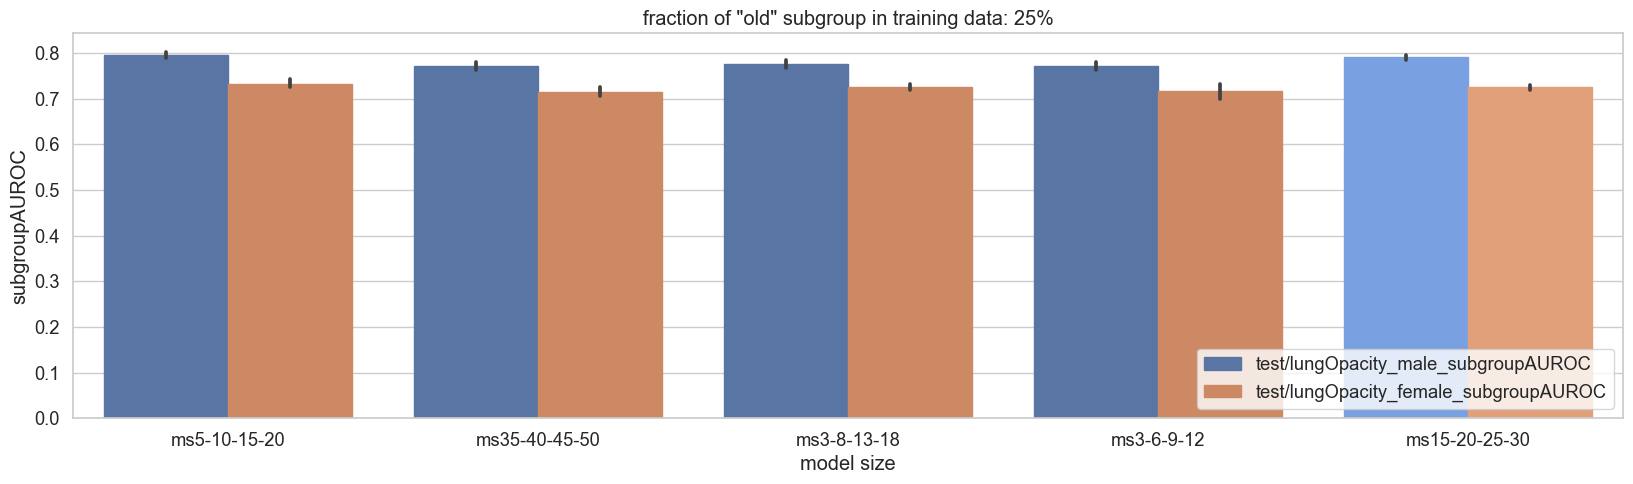

The 'most fair' model-size is at index 4 with size ms35-40-45-50


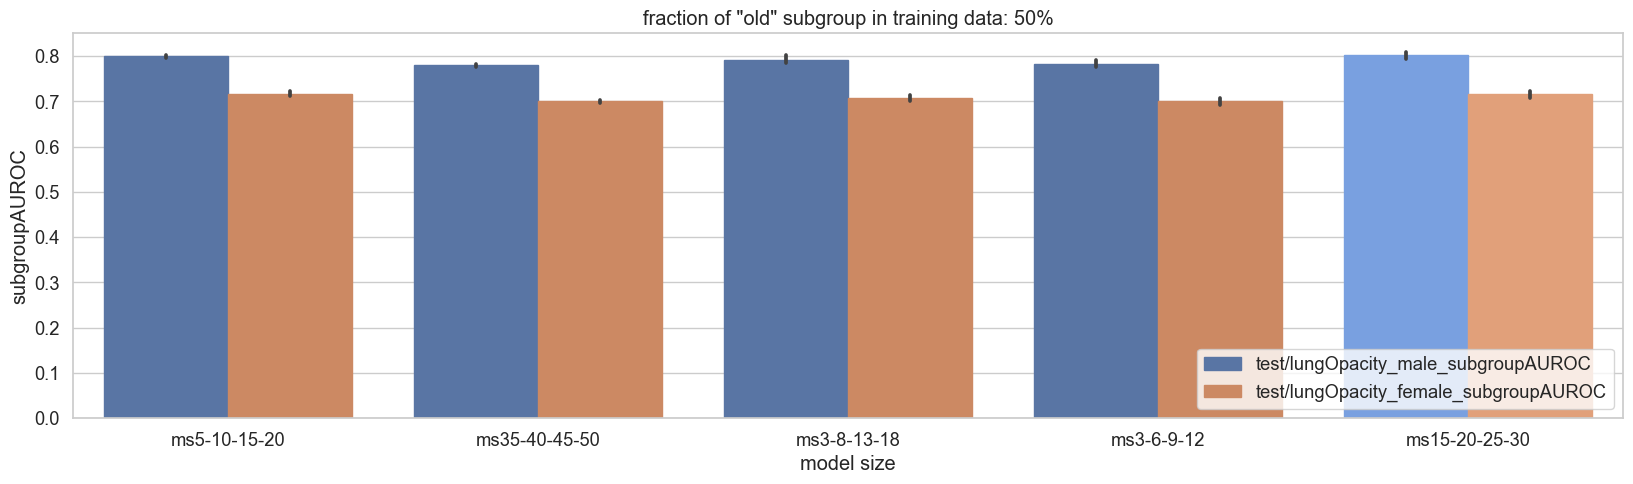

The 'most fair' model-size is at index 1 with size ms3-8-13-18


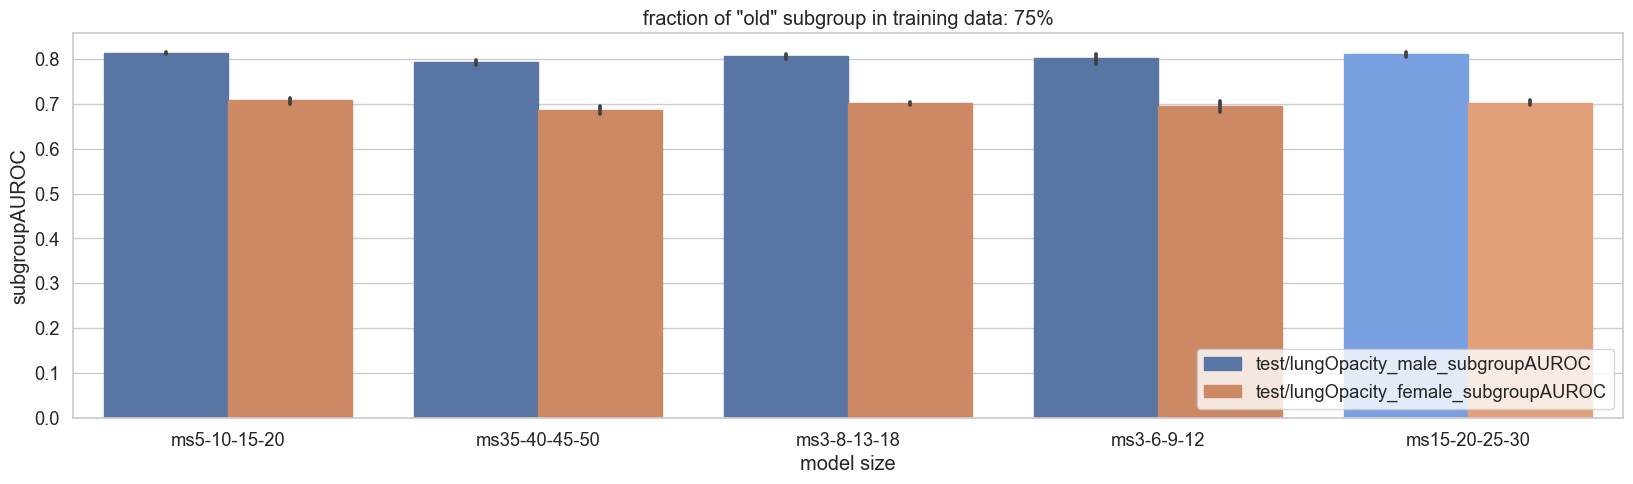

In [50]:
for split in df.protected_attr_percent.unique():
    only_auroc = True
    for metric in metrics:
        if only_auroc and not "subgroupAUROC" in metric[0]:
            continue
        min_dist = np.inf
        best_dss = None
        best_dss_max = None
        best_dss_min = None
        sub = df.loc[df['variable'].isin(metric[0:2]) & (df.protected_attr_percent==split)]
        for idx, w in enumerate(sizes):
            sub_w = sub[sub.job_type_mod==w]
            dist = sub_w.value.max() - sub_w.value.min()
            if dist < min_dist:
                min_dist = dist
                best_dss = idx
                best_dss_max = sub_w.value.max()
                best_dss_min = sub_w.value.min()
        print("The 'most fair' model-size is at index", best_dss, "with size", sizes[best_dss])
        # sort sub by variable
        sub = sub.sort_values(by=['variable'], ascending=True)
        generate_plot(sub, metric, split)